## Defining the Dataset

The [torchvision reference scripts for training object detection, instance segmentation and person keypoint detection](https://github.com/pytorch/vision/tree/v0.3.0/references/detection) allows for easily supporting adding new custom datasets.
The dataset should inherit from the standard `torch.utils.data.Dataset` class, and implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__` should return:

* image: a PIL Image of size (H, W)
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.
    * (optionally) `masks` (`UInt8Tensor[N, H, W]`): The segmentation masks for each one of the objects
    * (optionally) `keypoints` (`FloatTensor[N, K, 3]`): For each one of the `N` objects, it contains the `K` keypoints in `[x, y, visibility]` format, defining the object. `visibility=0` means that the keypoint is not visible. Note that for data augmentation, the notion of flipping a keypoint is dependent on the data representation, and you should probably adapt `references/detection/transforms.py` for your new keypoint representation

If your model returns the above methods, they will make it work for both training and evaluation, and will use the evaluation scripts from pycocotools.


One note on the labels. The model considers class 0 as background. If your dataset does not contain the background class, you should not have 0 in your labels. For example, assuming you have just two classes, cat and dog, you can define 1 (not 0) to represent cats and 2 to represent dogs. So, for instance, if one of the images has both classes, your labels tensor should look like [1,2].

Additionally, if you want to use aspect ratio grouping during training (so that each batch only contains images with similar aspect ratio), then it is recommended to also implement a `get_height_and_width` method, which returns the height and the width of the image. If this method is not provided, we query all elements of the dataset via `__getitem__` , which loads the image in memory and is slower than if a custom method is provided.


In [98]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt


# get group ids
def get_groups(image):
    id = image['id']
    group_set = set()
    try:
        for point in image.find_all('points'):
            group_set.add(point['group_id'])
        for box in image.find_all('box'):
            group_set.add(box['group_id'])
    except Exception as e:
        print( f'image {id} has no group ids' )
        return None

    return group_set

def create_pepper(group_id, image):

    pepper_bbox = None

    boxes = {
        'stem' : None,
        'body' : None,
    }

    kps = {
        'right_shoulder' : [0,0,0],
        'left_shoulder' : [0,0,0],
        'center_shoulder' : [0,0,0],
        'stem' : [0,0,0],
        'body' : [0,0,0],
    }

    # visibility:
    #   0: not labeled
    #   1: labeled, but not visible
    #   2: labeled, visible

    for point in image.find_all('points'):
        if point['group_id'] != group_id:
            continue
        label = point['label']
        points = point['points'] # should only be 1 in here
        xy_str = points.split(',')
        x = float(xy_str[0])
        y = float(xy_str[1])
        kps[label] = [x, y, 2]

    for box in image.find_all('box'):
        if box['group_id'] != group_id:
            continue
        label = box['label']
        boxes[label] = [
            float(box['xtl']),
            float(box['ytl']),
            float(box['xbr']),
            float(box['ybr']),
        ]    


    if boxes['stem'] is not None and boxes['pepper'] is not None:
        pepper_bbox = [
            min(boxes['stem'][0],boxes['pepper'][0]),
            min(boxes['stem'][1],boxes['pepper'][1]),
            max(boxes['stem'][2],boxes['pepper'][2]),
            max(boxes['stem'][3],boxes['pepper'][3]),
        ]

    elif boxes['pepper'] is not None:
        pepper_bbox = boxes['pepper']
    elif boxes['stem'] is not None:
        pepper_bbox = boxes['stem']
    

    area = (pepper_bbox[2] - pepper_bbox[0]) * (pepper_bbox[3] - pepper_bbox[1])

    
    kp_array = []
    kp_array.append(kps['right_shoulder'])
    kp_array.append(kps['left_shoulder'])
    kp_array.append(kps['center_shoulder'])
    kp_array.append(kps['stem'])
    kp_array.append(kps['body'])

    annotation = {
        "id" : group_id, # int,
        "image_id" : image['id'],# int,
        "category_id" : 1, # int,
        "segmentation" : None, # RLE or [polygon],
        "area" : area, # float,
        "bbox" : pepper_bbox, # [x,y,width,height],
        "iscrowd" : 0, #0 or 1,
        "keypoints": kp_array,# [x1,y1,v1,...],
        "num_keypoints" : 5, # : int,
    }

    return annotation


# pass beaustiful soup image object
def parse_image(image):

    image_data = {
        "id" : image['id'], # int,
        "width" : image['width'], # int,
        "height" : image['height'], # int,
        "file_name" : image['name'], #str,
        "license" : 0, # int,
        "flickr_url" : "", # str,
        "coco_url" : "", #str,
        "date_captured": None, #datetime,
    }

    groups = get_groups(image)
    if groups is None:
        return image_data, None

    annotations = []
    for group_id in groups:
        pepper = create_pepper(group_id, image)
        annotations.append(pepper)



    return image_data, annotations


# parse the annotations file and return a organized object
def parse_annotations(file_path):

    images = []
    annotations = []

    with open(file_path, 'r') as xml_doc:
        soup = BeautifulSoup(xml_doc, 'lxml')
        #print(soup.prettify())

        for image in soup.find_all('image'):
            im, anno = parse_image(image)
            images.append(im)
            annotations.append(anno)

    # print(len(images))
    # print(len(annotations))

    # print(images[0])
    # print(annotations[0])

    return images, annotations

class PepperDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.images, self.annotations = parse_annotations(annotations_file)
        self.img_dir = img_dir

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):

        # get the image
        img_path = os.path.join(
            self.img_dir, 
            (self.images[idx])['file_name'])
        image = read_image(img_path)

        # get the annotations
        annos = self.annotations[idx]
        num_objs = len(annos)
        
        boxes = []
        kps = []
        area = []

        for anno in annos:
            boxes.append(anno['bbox'])
            kps.append(anno['keypoints'])
            area.append(anno['area'])
        
        # convert to tensors
        labels = torch.ones((num_objs,), dtype=torch.int64)
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        boxes = torch.tensor(boxes, dtype=torch.float32)
        area = torch.as_tensor(area, dtype=torch.float32)
        keypoints = torch.tensor(kps, dtype=torch.float32)
        image_id = torch.tensor([idx])


        # if self.transform:
        #     image = self.transform(image)
        # if self.target_transform:
        #     label = self.target_transform(label)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        # target["masks"] = masks_tensor
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        target["keypoints"] = keypoints
        
        
        return image, target



In [99]:
ds = PepperDataset('annotations.xml', 'images')

im, target = ds[1]



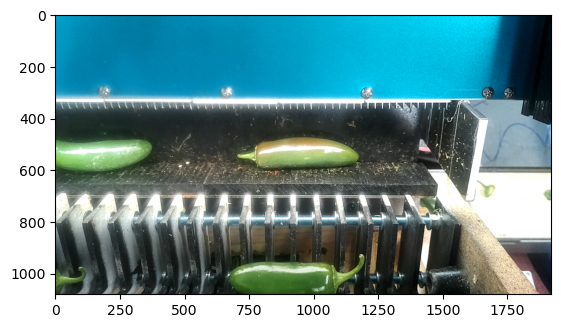

In [100]:
plt.imshow(  im.permute(1, 2, 0)  )

In [101]:
im

tensor([[[  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   1,   2],
         ...,
         [ 37,  36,  38,  ...,  48,  45,  45],
         [ 34,  33,  39,  ...,  47,  47,  49],
         [ 31,  31,  40,  ...,  50,  47,  48]],

        [[165, 166, 166,  ...,   9,   9,  10],
         [166, 166, 166,  ...,   8,   9,  10],
         [167, 167, 166,  ...,   9,  10,  11],
         ...,
         [ 57,  56,  58,  ...,  37,  34,  36],
         [ 54,  53,  59,  ...,  34,  34,  38],
         [ 51,  51,  60,  ...,  35,  34,  35]],

        [[207, 208, 208,  ...,   8,   8,   9],
         [208, 208, 208,  ...,   7,   8,   9],
         [209, 209, 208,  ...,   8,   9,  10],
         ...,
         [ 30,  29,  31,  ...,  43,  40,  41],
         [ 29,  28,  34,  ...,  41,  41,  44],
         [ 26,  26,  35,  ...,  42,  41,  42]]], dtype=torch.uint8)

In [102]:
target

{'boxes': tensor([[ 705.1900,  474.0700, 1177.7800,  598.5200],
         [   0.0000,  482.9600,  379.2600,  611.9000]]),
 'labels': tensor([1, 1]),
 'image_id': tensor([1]),
 'area': tensor([58813.8242, 48901.7852]),
 'iscrowd': tensor([0, 0]),
 'keypoints': tensor([[[789.6300, 499.2600,   2.0000],
          [794.2000, 590.0000,   2.0000],
          [786.4200, 542.3200,   2.0000],
          [761.4800, 545.1900,   2.0000],
          [964.4400, 534.8100,   2.0000]],
 
         [[  0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000],
          [149.6300, 545.1900,   2.0000]]])}

In [104]:
from torchvision.utils import draw_bounding_boxes
from torchvision.utils import draw_keypoints
import torch

bboxes = target['boxes']
bboxes = [
    anno[0]['bbox'],
    anno[1]['bbox'],
]

bboxes_tensor = torch.tensor(bboxes)
bboxes_tensor

kps = []
for a in anno:
    kps.append(a['keypoints'])
    
kps_tensor = torch.tensor(kps)

just_2 = kps_tensor[:,:,:2]
just_2

tensor([[[789.6300, 499.2600],
         [794.2000, 590.0000],
         [786.4200, 542.3200],
         [761.4800, 545.1900],
         [964.4400, 534.8100]],

        [[  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [149.6300, 545.1900]]])

In [105]:
connectivity = [
    [0,2],
    [1,2],
    [3,2],
    [4,2],
]

just_2.nonzero()

tensor([[0, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 1],
        [0, 2, 0],
        [0, 2, 1],
        [0, 3, 0],
        [0, 3, 1],
        [0, 4, 0],
        [0, 4, 1],
        [1, 4, 0],
        [1, 4, 1]])

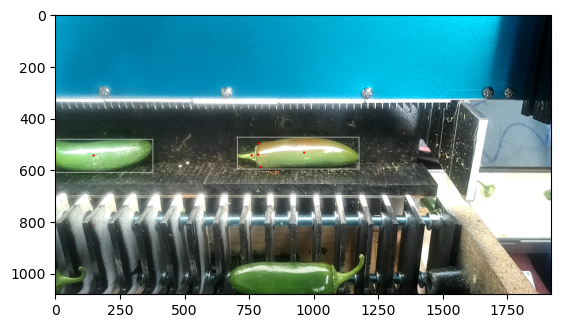

In [106]:


im2 = draw_bounding_boxes(im, bboxes_tensor, colors='white', width=2)
im2 = draw_keypoints(im2, just_2, width = 2, radius=4, colors='red')

plt.imshow(  im2.permute(1, 2, 0)  )